In [44]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [45]:
!ls german-traffic-signs

signnames.csv test.p        train.p       valid.p


In [70]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import random
import pickle
import pandas as pd
import cv2

In [47]:
np.random.seed(0)

In [48]:
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)

print(type(train_data))

xtrain_data, ytrain_data = train_data['features'], train_data['labels']
xval_data, yval_data = val_data['features'], val_data['labels']
xtest_data, ytest_data = test_data['features'], test_data['labels']


<class 'dict'>


In [49]:
print(xtrain_data.shape)
print(xval_data.shape)
print(xtest_data.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [50]:
assert(xtrain_data.shape[0] == ytrain_data.shape[0]), "The number of images is not equal to number of labels."
assert(xtest_data.shape[0] == ytest_data.shape[0]), "The number of images is not equal to number of labels."
assert(xval_data.shape[0] == yval_data.shape[0]), "The number of images is not equal to number of labels."
assert(xtrain_data.shape[1:] == (32,32,3)), "The dimentions of image is not equal to 32x32"
assert(xtest_data.shape[1:] == (32,32,3)), "The dimentions of image is not equal to 32x32"
assert(xval_data.shape[1:] == (32,32,3)), "The dimentions of image is not equal to 32x32"

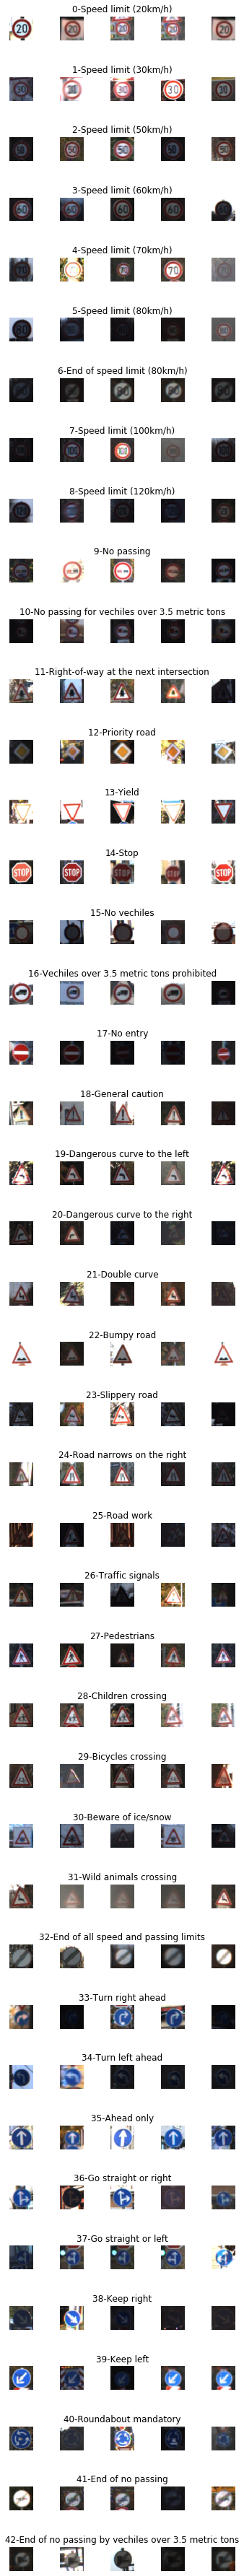

In [51]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
num_of_samples = []

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = xtrain_data[ytrain_data == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row['SignName'])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

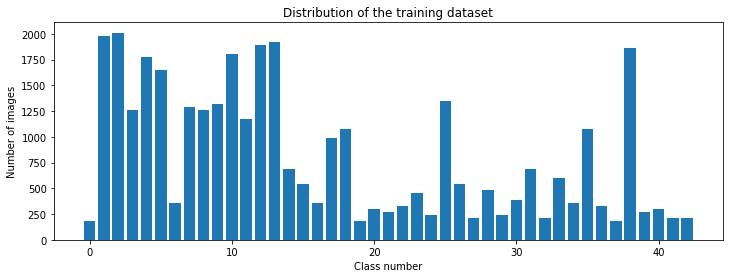

In [52]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

In [53]:
def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img/255
    return img

In [54]:
xtrain_data = np.array(list(map(preprocess_image, xtrain_data)))
xval_data = np.array(list(map(preprocess_image, xval_data)))
xtest_data = np.array(list(map(preprocess_image, xtest_data)))

In [55]:
xtrain_data = xtrain_data.reshape(xtrain_data.shape[0], 32, 32, 1)
xval_data = xval_data.reshape(xval_data.shape[0], 32, 32, 1)
xtest_data = xtest_data.reshape(xtest_data.shape[0], 32, 32, 1)

In [72]:
datagen = ImageDataGenerator(
                width_shift_range=0.1,
                height_shift_range=0.1,
                zoom_range=0.2,
                shear_range=0.1,
                rotation_range=10)

datagen.fit(xtrain_data)

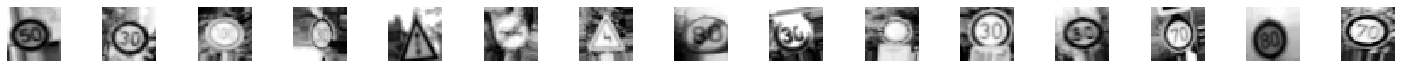

In [73]:
batches = datagen.flow(xtrain_data, ytrain_data, batch_size=20)
xbatch_data, ybatch_data = next(batches)

fig1, axs1 = plt.subplots(1, 15, figsize=(20, 5))
fig1.tight_layout()
for i in range(15):
    axs1[i].imshow(xbatch_data[i].reshape(32,32), cmap=plt.get_cmap("gray"))
    axs1[i].axis("off")

In [56]:
print(xtrain_data.shape)
print(xval_data.shape)
print(xtest_data.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [57]:
ytrain_data = to_categorical(ytrain_data, 43) # one hot encoding
yval_data = to_categorical(yval_data, 43) # one hot encoding
ytest_data = to_categorical(ytest_data, 43) # one hot encoding

In [67]:
def lenet_model():
    model = Sequential()
    model.add(Conv2D(60, (5,5), input_shape=(32,32,1), activation="relu"))
    model.add(Conv2D(60, (5,5), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(30, (3,3), activation="relu"))
    model.add(Conv2D(30, (3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(500, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [68]:
model = lenet_model()
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 4, 30)         

In [69]:
#history = model.fit(xtrain_data, ytrain_data, epochs=10, 
#                    validation_data=(xval_data, yval_data), verbose=1, batch_size=400, shuffle=1)

history = model.fit_generator(datagen.flow(xtrain_data, ytrain_data, batch_size=50),
                              steps_per_epoch=2000, epochs=10, validation_data=(xval_data, yval_data), 
                              verbose=1, batch_size=400, shuffle=1)

Train on 34799 samples, validate on 4410 samples
Epoch 1/10
 2800/34799 [=>............................] - ETA: 17:32 - loss: 3.6905 - accuracy: 0.0346

KeyboardInterrupt: 

Text(0.5, 0, 'epoch')

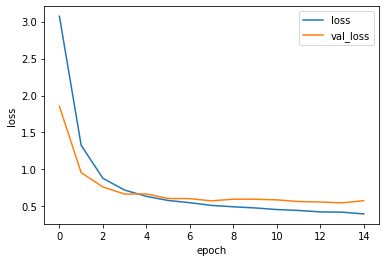

In [64]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

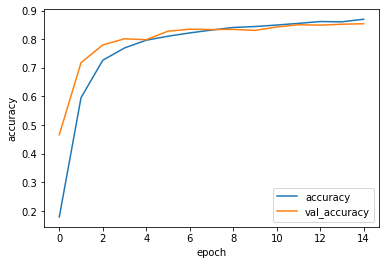

In [65]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [66]:
score = model.evaluate(xtest_data, ytest_data)
print(score)
print("Test score", score[0])
print("Test accuracy", score[1])

12630/12630 [==============================] - 5s 414us/step
[0.7799390580478587, 0.8103721141815186]
Test score 0.7799390580478587
Test accuracy 0.8103721141815186
